In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import ctc_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

# seed for reproducibility
np.random.seed(785)
torch.manual_seed(785)
torch.cuda.manual_seed(785)

### Generate the dataset

In [2]:
# Check if data already exists and synthesize if not
if not os.path.exists("dataset") or (os.listdir("dataset")) == 0:
    import mkSeqMNIST as data_synthesizer
    data_synthesizer.make()

### Load the dataset

In [3]:
data, labels = np.load("dataset/data.npy"), np.load("dataset/labels.npy")

Note that the data is `(num_samples, height, width)` and labels are integer sequences of length 10, `(num_samples, 10)`.

In [4]:
print(data.shape)
print(labels.shape)

(20000, 36, 172)
(20000, 10)


### Train or load pretrained model

In [7]:
train = False
model_file = "example.pt"
if train:
    ctc_model.run()
model = ctc_model.DigitsModel()
model.load_state_dict(torch.load(model_file))
print(model)

DigitsModel(
  (embed): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (1): ELU(alpha=1.0)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ELU(alpha=1.0)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ELU(alpha=1.0)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ELU(alpha=1.0)
  )
  (rnns): ModuleList(
    (0): LSTM(288, 256)
  )
  (output_layer): Linear(in_features=256, out_features=11, bias=True)
)


### Let's read some handwriting!

torch.Size([15, 100, 86])


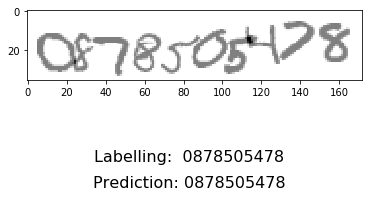

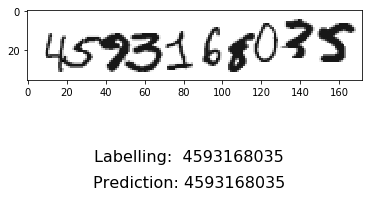

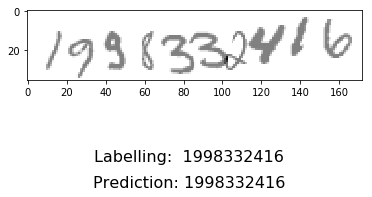

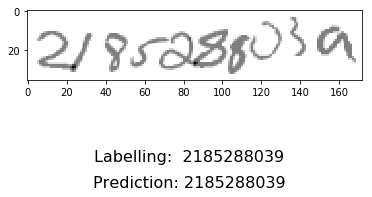

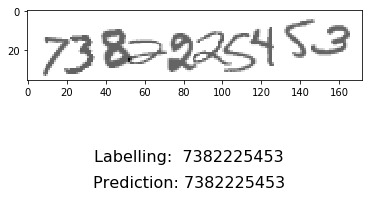

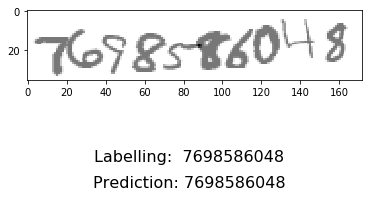

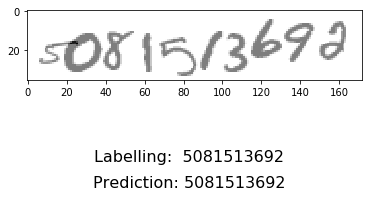

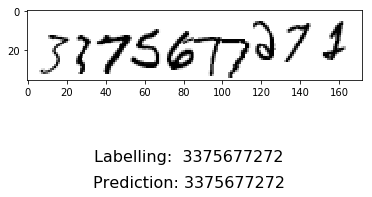

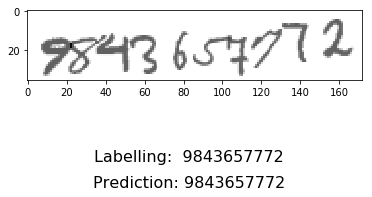

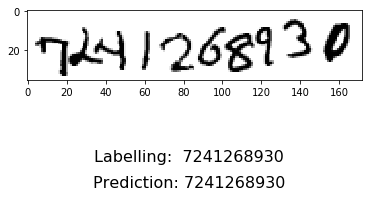

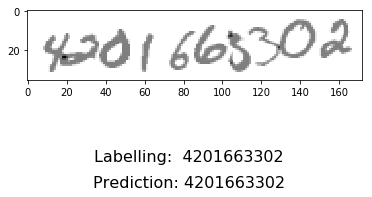

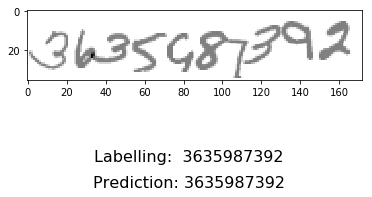

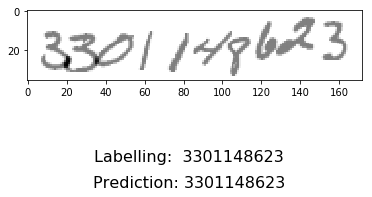

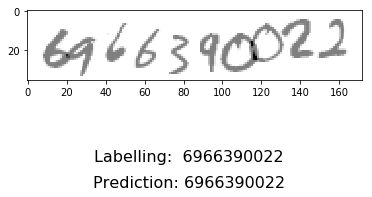

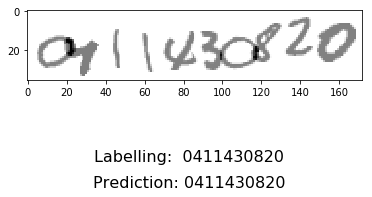

In [8]:
label_map = [' '] + ctc_model.DIGITS_MAP

decoder = ctc_model.CTCBeamDecoder(labels=label_map, blank_id=0)

# randomly sample 15 data points
idxs = np.random.choice(20000, 15)
data_batch, label_batch = torch.Tensor(data[idxs]), torch.Tensor(labels[idxs]).long()

logits, out_lengths = model(data_batch.unsqueeze(1))
label_lengths = torch.zeros((15,)).fill_(10)
logits = torch.transpose(logits, 0, 1)
probs = F.softmax(logits, dim=2).data.cpu()
output, scores, timesteps, out_seq_len = decoder.decode(probs=probs, seq_lens=out_lengths)
print(output.size())
for i in range(output.size(0)):
    chrs = [label_map[o.item()] for o in output[i, 0, :out_seq_len[i, 0]]]

    image = data_batch[i].numpy()
    plt.figure()
    imshow(image, cmap='binary')
    txt_top = "Prediction: {}".format("".join(chrs))
    txt_bottom = "Labelling:  {}".format("".join(label_batch[i].numpy().astype(str)))
    plt.figtext(0.5, 0.01, txt_top, wrap=True, horizontalalignment='center', fontsize=16)
    plt.figtext(0.5, 0.10, txt_bottom, wrap=True, horizontalalignment='center', fontsize=16)

